In [ ]:
# !pip install metrics
# !pip install dataloader
# !pip install lightgbm

In [13]:
import process_encoding as pe
df = pe.load_df()
df.head()

C:\3team_2nd\process_encoding.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X.Churn = X.Churn.replace("No", 0)
C:\3team_2nd\process_encoding.py:31: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X.CreditRating = X.CreditRating.replace("7-Lowest", 7)


,Churn,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,PercChangeMinutes,PercChangeRevenues,DroppedCalls,...,Occupation_Professional,Occupation_Retired,Occupation_Self,Occupation_Student,ServiceArea_Center,ServiceArea_East,ServiceArea_West,ServiceArea_None,BuysViaMailOrder_No,BuysViaMailOrder_Yes
0,1,24.00,219.0,22.0,0.25,0.0,0.0,-157.0,-19.0,0.7,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,1,16.99,10.0,17.0,0.00,0.0,0.0,-4.0,0.0,0.3,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,0,38.00,8.0,38.0,0.00,0.0,0.0,-2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,0,82.28,1312.0,75.0,1.24,0.0,0.0,157.0,8.1,7.7,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,1,17.14,0.0,17.0,0.00,0.0,0.0,0.0,-0.2,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [14]:
df.to_csv(f"dataset/encoded_data.csv", index=False)
# df.ServiceArea.valuecount()

In [15]:
%%writefile dataloader.py
import pandas as pd

def load_dataset():
    # load dataset
    data = pd.read_csv('dataset/train_result.csv')
    # 컬럼명 소문자로 변경
    data.columns = data.columns.str.lower()
    # target 컬럼을 y로, 나머지를 X로
    X = data.drop(columns='churn')
    y = data['churn']
    
    return X, y
    

Overwriting dataloader.py


In [16]:
from sklearn.model_selection import train_test_split
from dataloader import load_dataset
from dataloader import load_testset
from sklearn.model_selection import train_test_split

X, y = load_dataset()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=0)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, stratify=y_train, random_state=0)

In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

models = [
    ("LR", LogisticRegression(random_state=0, max_iter=3000)),
    ("GBM", GradientBoostingClassifier(random_state=0)),
    ("RF", RandomForestClassifier(random_state=0)),
    ("KNN", KNeighborsClassifier()),
    ("XGB", XGBClassifier(random_state=0)),
    ("TREE",DecisionTreeClassifier(random_state=0)),
    ("LGBM", LGBMClassifier(random_state=0))
]

In [18]:
baseline_result_train_dict = {}
baseline_result_valid_dict = {}


for name, model in models:
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    
    pred_valid = model.predict(X_valid)
    pred_proba_valid = model.predict_proba(X_valid)[:, 1]

    accuracy_valid = accuracy_score(y_valid, pred_valid)
    precision_valid = precision_score(y_valid, pred_valid)
    recall_valid = recall_score(y_valid, pred_valid)
    f1_valid = f1_score(y_valid, pred_valid)
    auc_valid = roc_auc_score(y_valid, pred_proba_valid)
    
    baseline_result_valid_dict[name] = [accuracy_valid, precision_valid, recall_valid, f1_valid, auc_valid]

Training LR...


C:\Users\Playdata\miniconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training GBM...
Training RF...
Training KNN...
Training XGB...
Training TREE...
Training LGBM...
[LightGBM] [Info] Number of positive: 8013, number of negative: 19972
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008210 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2878
[LightGBM] [Info] Number of data points in the train set: 27985, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.286332 -> initscore=-0.913266
[LightGBM] [Info] Start training from score -0.913266


In [19]:
import pandas as pd
pd.DataFrame(baseline_result_valid_dict, index=['accuracy', 'precision', 'recall', 'f1', 'roc-auc'])

,LR,GBM,RF,KNN,XGB,TREE,LGBM
accuracy,0.714224,0.721514,0.716797,0.668989,0.704041,0.619466,0.718191
precision,0.571429,0.646586,0.552727,0.357679,0.457306,0.339305,0.542339
recall,0.007488,0.060277,0.056908,0.196181,0.180457,0.347435,0.100711
f1,0.014782,0.110274,0.103191,0.253385,0.258792,0.343322,0.169877
roc-auc,0.603077,0.662349,0.645247,0.557543,0.637926,0.538016,0.661267


In [20]:
import joblib
import os

os.makedirs('models', exist_ok=True)

In [40]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

# DecisionTreeClassifier에 맞는 하이퍼파라미터 범위 설정
param_dtree = {
    'max_depth': range(1, 21),              # 트리의 최대 깊이
    'min_samples_split': range(2, 21),     # 노드를 분할하기 위한 최소 샘플 수
    'min_samples_leaf': range(1, 21),      # 리프 노드에 있어야 하는 최소 샘플 수
    'criterion': ['gini', 'entropy'],      # 분할 기준
    'max_features': [None, 'sqrt', 'log2'] # 선택할 특성의 개수
}

param_xgb = {
    'learning_rate': [0.001, 0.01, 0.1, 0.2,],
    'n_estimators': [1000, 2000, 3000, 4000, 5000, 6000],
    'max_depth': range(1, 7),
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1]
}

# Initialize RandomizedSearchCV for each model
random_search_dtree = RandomizedSearchCV(DecisionTreeClassifier(random_state=0),param_dtree, cv=4, scoring='f1', n_jobs=-1, n_iter=60, random_state=0)
random_search_xgb = RandomizedSearchCV(XGBClassifier(random_state=0), param_xgb, cv=4, scoring='f1', n_jobs=-1, n_iter=60, random_state=0)

print("DecisionTreeClassifier 튜닝...")
random_search_dtree.fit(X_train, y_train)

print("XGBClassifier 튜닝...")
random_search_xgb.fit(X_train, y_train);

DecisionTreeClassifier 튜닝...
XGBClassifier 튜닝...


In [31]:
## Best parameter 확인
print("DecisionTreeClassifier Best parameters:", random_search_dtree.best_params_)
print("XGBClassifier Best parameters:", random_search_xgb.best_params_)

DecisionTreeClassifier Best parameters: {'min_samples_split': 11, 'min_samples_leaf': 13, 'max_features': None, 'max_depth': 19, 'criterion': 'gini'}
XGBClassifier Best parameters: {'subsample': 1, 'n_estimators': 5000, 'max_depth': 4, 'learning_rate': 0.2}


In [32]:
print("DecisionTreeClassifier Best score:", random_search_dtree.best_score_)
print("XGBClassifier Best score:", random_search_xgb.best_score_)

DecisionTreeClassifier Best score: 0.31162699122128873
XGBClassifier Best score: 0.3242989028195077


In [36]:
best_dtree = random_search_dtree.best_estimator_
best_xgb = random_search_xgb.best_estimator_

In [37]:
import joblib
joblib.dump(best_dtree, 'models/best_dtree.pkl')
joblib.dump(best_xgb, 'models/best_xgb.pkl')

print("Models saved successfully.")

Models saved successfully.


In [38]:
best_models = [
    ("DecisionTreeClassifier", best_dtree),
    ("XGBClassifier", best_xgb)
]

test_results = {}

for name, model in best_models:
    print(f"평가 {name}...")
    pred_test = model.predict(X_test)
    pred_proba_test = model.predict_proba(X_test)[:, 1]

    accuracy_test = accuracy_score(y_test, pred_test)
    precision_test = precision_score(y_test, pred_test)
    recall_test = recall_score(y_test, pred_test)
    f1_test = f1_score(y_test, pred_test)
    auc_test = roc_auc_score(y_test, pred_proba_test)
    
    test_results[name] = [accuracy_test, precision_test, recall_test, f1_test, auc_test]

평가 DecisionTreeClassifier...
평가 XGBClassifier...


In [39]:
pd.DataFrame(test_results, index=['accuracy', 'precision', 'recall', 'f1', 'roc-auc'])

,DecisionTreeClassifier,XGBClassifier
accuracy,0.662888,0.684354
precision,0.379573,0.419284
recall,0.279697,0.266217
f1,0.322070,0.325661
roc-auc,0.581006,0.613711


C:\Users\Playdata\miniconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


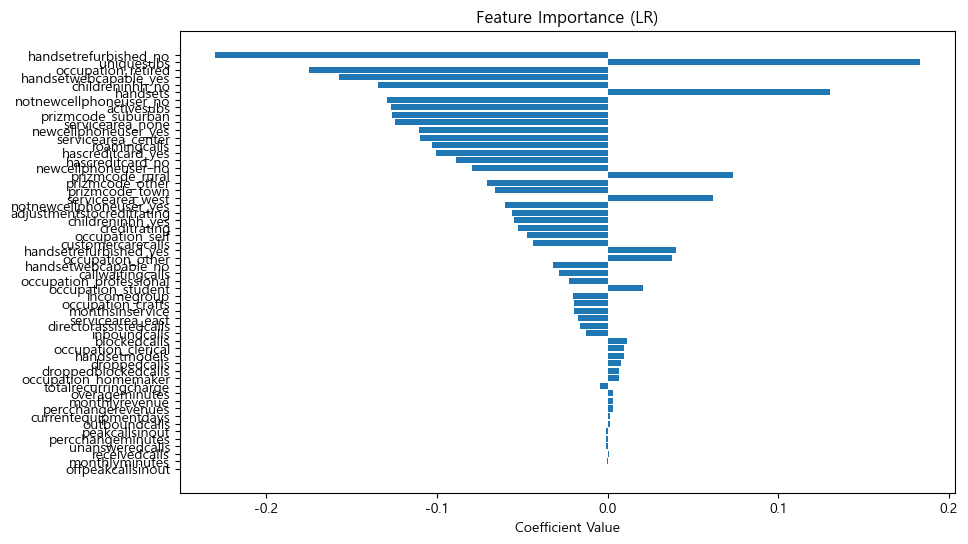

In [25]:
#LogisticRegression을 통한 Feature Importance 시각화 
import matplotlib.pyplot as plt
import numpy as np

model_lr = LogisticRegression(random_state=0, max_iter=3000)

model_lr.fit(X_train, y_train)

# coefficient

coefficients = model_lr.coef_[0]
indices = np.argsort(np.abs(coefficients))  
plt.figure(figsize=(10, 6))
plt.title("Feature Importance (LR)")
plt.barh(range(len(indices)), coefficients[indices], align="center")
plt.yticks(range(len(indices)), [X_train.columns[i] for i in indices])
plt.xlabel("Coefficient Value")
plt.show()